This notebook shows how to setup a new project, train a keypoint-MoSeq model and visualize the resulting syllables. You can load keypoint tracking results from SLEAP, DeepLabCut, or using your own custom format. We provide an [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link) that can be used for the tutorial.

# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [1]:
# run this code after creating a project

import keypoint_moseq as kpms

project_dir = 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/AVATAR/pilot_test/'
video_dir= [r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_111.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_112.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_113.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_121.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_122.csv'
]
config = lambda: kpms.load_config(project_dir)

In [1]:
import keypoint_moseq as kpms

bodyparts = ['nose','neck','anus','chest','rfoot','lfoot','rhand','lhand','tip']

skeleton=[
    ['neck', 'chest'],
    ['chest', 'anus'],
    ['nose', 'neck'],
    ['lhand', 'chest'],
    ['lfoot', 'anus'],
    ['rhand', 'chest'],
    ['rfoot', 'anus'],
    ['anus', 'tip']]

project_dir = 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/AVATAR/pilot_test/'
video_dir= [r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_111.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_112.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_113.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_121.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_122.csv'
]

kpms.setup_project(
    project_dir,
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton)

The directory `C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-
moseq/AVATAR/pilot_test/` already exists. Use `overwrite=True` or pick
a different name


## Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

Edit the config as follows for the [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link):

In [8]:
kpms.update_config(
    project_dir,
    video_dir=video_dir,
    anterior_bodyparts=['nose'],
    posterior_bodyparts=['anus'],
    use_bodyparts=['nose','neck','anus','chest','rfoot','lfoot','rhand','lhand']
)

## Load data

We provide loading functions for DeepLabCut, SLEAP, anipose, and SLEAP-anipose. In every case, the keypoint data are loaded to the following pair of dictionaries:
- `coordinates`: dict from session names to keypoint coordinate arrays of shape (T,K,2 [or 3]) 
- `confidences`: dict from session names to **nonnegative** keypoint confidence arrays of shape (T,K) 

```{note}
- `confidences` are optional (they are used to set the error prior for each observation)
- each key in `coordinates` should start with its video name 
    - e.g. `coordinates["experiment1_etc"]` would correspond to `experiment1.avi`
    - in general this will already be true if importing from SLEAP or DeepLabCut
```

In [2]:
# Junesu modification
video_dir= video_dir

# load data from AVATAR .csv file
keypoint_data_path = [r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_111.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_112.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_113.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_121.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_122.csv'
] # can be a file, a directory, or a list of files

coordinates, bodyparts = kpms.load_keypoints_AVATAR(keypoint_data_path, path_sep='_', path_in_name=True, remove_extension=True)

# format data for modeling
data, labels = kpms.format_data(coordinates, **config())

Loading keypoints: 100%|██████████| 5/5 [00:00<00:00, 24.47it/s]


## Calibration

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. One can also adjust the `confidence_threshold` parameter at this step, which is used to define outlier keypoints for PCA and model initialization. **This step can be skipped for the demo data** since the config already includes suitable regression coefficients.

- Run the cell below. A widget should appear with a video frame on the left.
    - *If the widget doesn't render, try using jupyter lab instead of jupyter notebook*
    
- Annotate each frame with the correct location of the labeled bodypart
    - Left click to specify the correct location - an "X" should appear.
    - Use the arrow buttons to annotate additional frames.
    - Each annotation adds a point to the right-hand scatter plot. 
    - Continue until the regression line stabilizes.
   
- At any point, adjust the confidence threshold by clicking on the scatter plot.

- Use the "save" button to update the config and store your annotations to disk.

Loading sample frames: 100%|█████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 46.47it/s]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
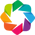

Column
    [0] Row
        [0] Button(align='center', name='◀', width=50)
        [1] Button(align='center', name='▶', width=50)
        [2] Spacer(sizing_mode='stretch_width')
        [3] IntSlider(align='center', end=640, name='Zoom', start=1, value=200, width=100)
        [4] Spacer(sizing_mode='stretch_width')
        [5] Button(align='center', name='Save:', width=100)
        [6] Spacer(sizing_mode='stretch_width')
        [7] StaticText(align='center', value='slope: -0.500000<br>inter...)
    [1] Row
        [0] HoloViews(DynamicMap)
        [1] HoloViews(DynamicMap)

In [6]:
kpms.noise_calibration(project_dir, coordinates, confidences, **config())

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates. The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``. Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 

- After fitting, edit `latent_dimension` in the config. 
- A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 10 components.


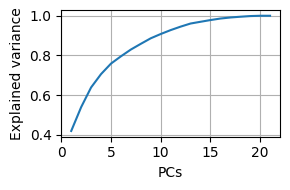

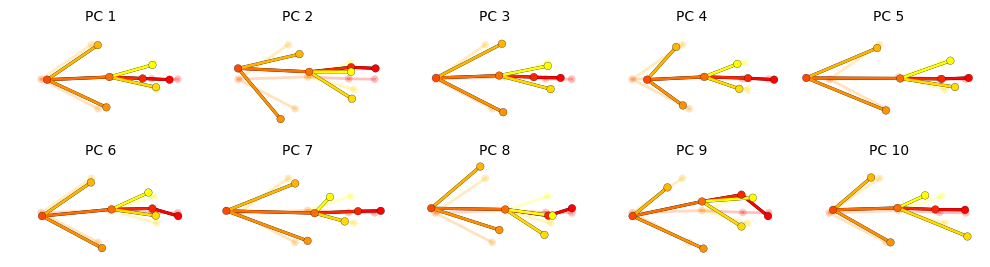

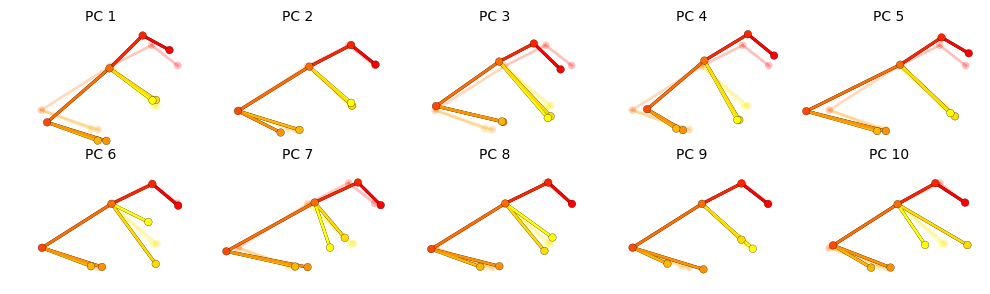

In [3]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# use the following to load an already 
# pca = kpms.load_pca(project_dir)

In [4]:
kpms.update_config(project_dir, latent_dim=10)

# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling. 
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. PCA trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Apply the trained model:** The learned model parameters are used to infer a syllable sequence for each experiment. This step should always be applied at the end of model fitting, and it can also be used later on to infer syllable sequences for newly added data.

## Setting hyperparameters

There are two ways to change hyperparameters:
1. Update the config using `kpms.update_config` and then re-initialize the model
2. Change the model directly via `kpms.update_hypparams`

In general, the main hyperparam that needs to be adjusted is **kappa**, which sets the time-scale of syllables. Higher kappa leads to longer syllables. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). In general, you will need to tune kappa for each new dataset based on the intended syllable time-scale. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and kappa can be adjusted as described above.
- The full model will generally require a lower value of kappa to yield the same target syllable durations.


## Initialization

In [5]:
# optionally update kappa in the config before initializing 
# kpms.update_config(project_dir=project_dir, kappa=NUMBER)

# initialize the model
model = kpms.init_model(data, pca=pca, **config())

## Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a new directory in `project_dir`
- saves a checkpoint every 10 iterations from which fitting can be restarted
    - a single checkpoint file contains the full history of fitting, and can be used to restart fitting from any iteration
- plots the progress of fitting every 10 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - the syllable sequence across iterations in a random window

Outputs will be saved to C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-
moseq/AVATAR/pilot_test/2023_07_07-18_50_32


  0%|          | 0/51 [00:00<?, ?it/s]

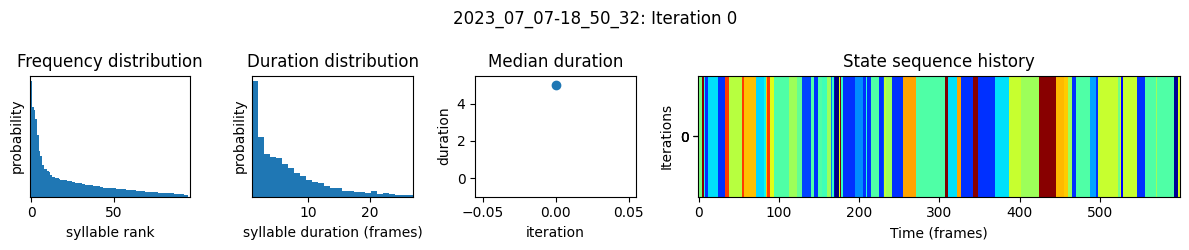

 20%|█▉        | 10/51 [03:04<12:11, 17.85s/it]

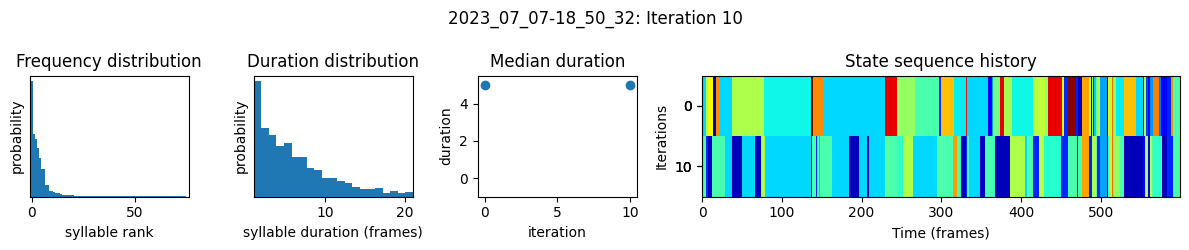

 39%|███▉      | 20/51 [06:04<09:16, 17.96s/it]

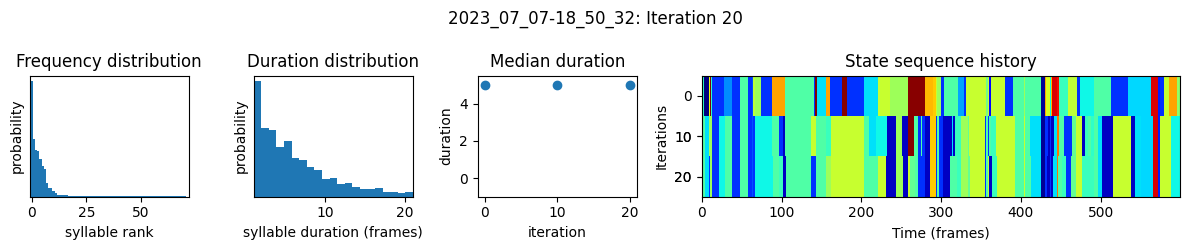

 59%|█████▉    | 30/51 [09:04<06:16, 17.92s/it]

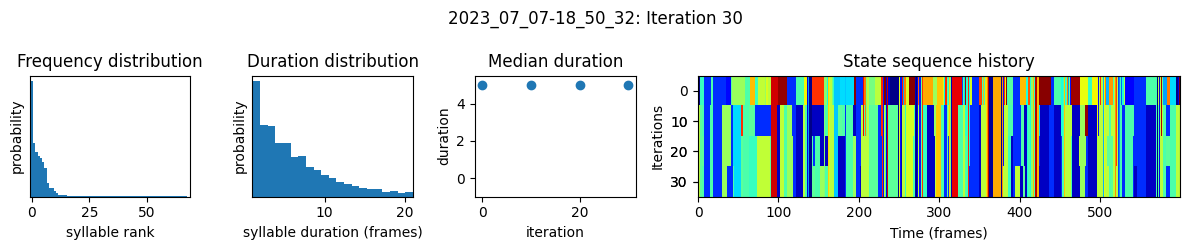

 78%|███████▊  | 40/51 [12:01<03:15, 17.75s/it]

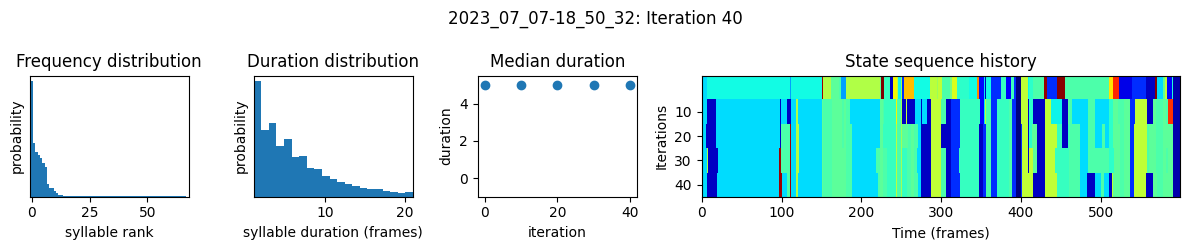

 98%|█████████▊| 50/51 [15:01<00:17, 17.92s/it]

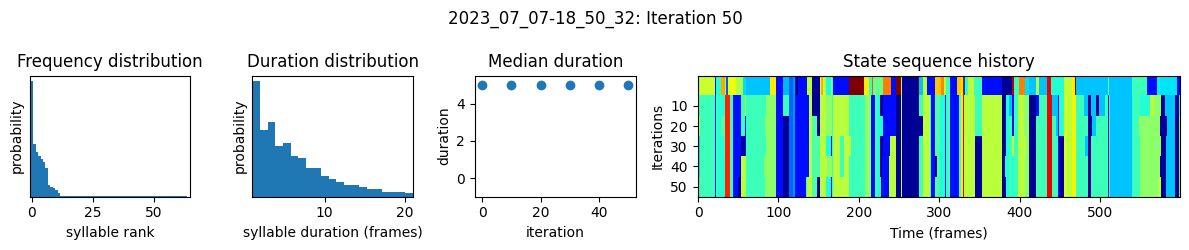

100%|██████████| 51/51 [15:20<00:00, 18.04s/it]


In [6]:
model, history, name = kpms.fit_model(model, data, labels, ar_only=True, 
                                      num_iters=50, project_dir=project_dir)

## Fitting the full model

The following code fits a full keypoint-MoSeq model, using the results of AR-HMM fitting for initialization
- If using your own data, you may need to try a few values of kappa at this step. 
- Use `kpms.revert` to resume from the same starting point each time you restart fitting

Outputs will be saved to C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-
moseq/AVATAR/pilot_test/2023_07_07-18_50_32


  4%|▍         | 9/200 [09:31<3:18:24, 62.32s/it]

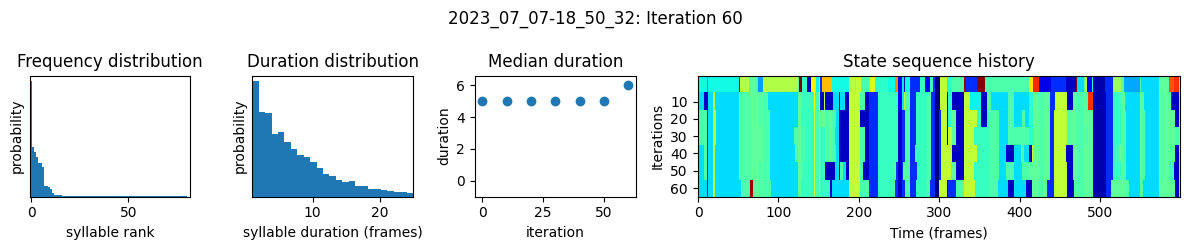

 10%|▉         | 19/200 [19:48<3:06:02, 61.67s/it]

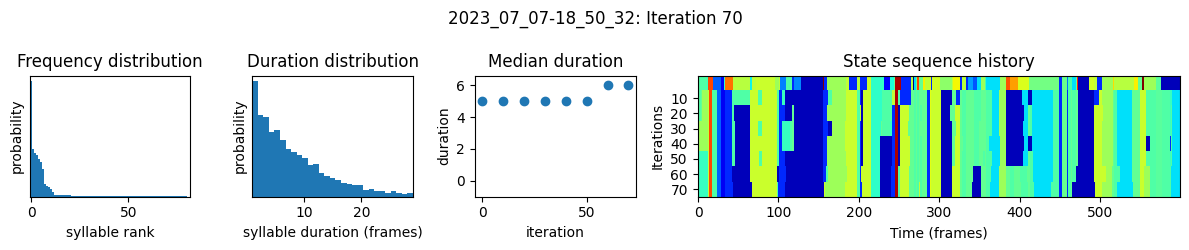

 14%|█▍        | 29/200 [30:05<2:55:35, 61.61s/it]

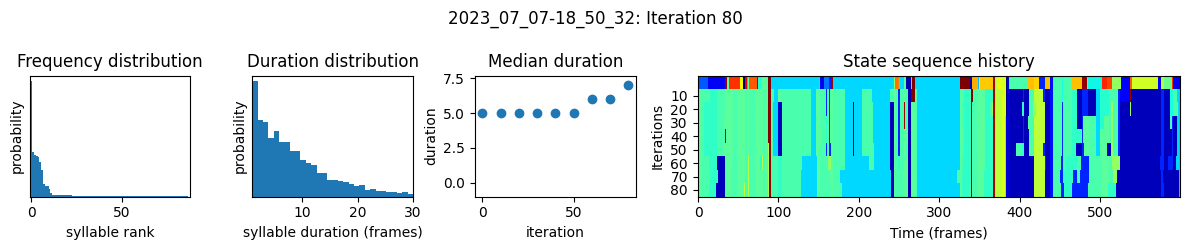

 20%|█▉        | 39/200 [40:23<2:45:47, 61.79s/it]

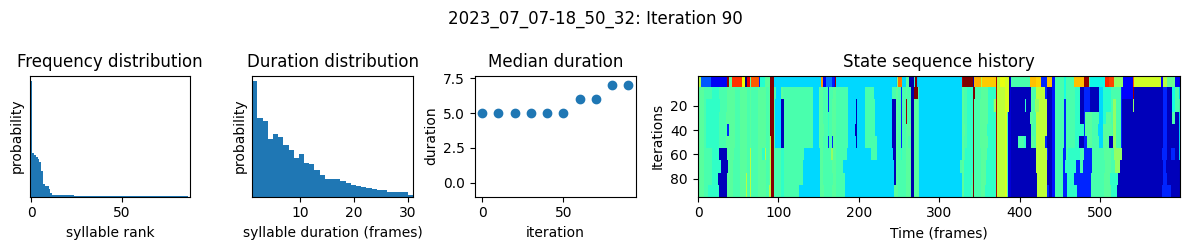

 24%|██▍       | 49/200 [50:40<2:35:10, 61.66s/it]

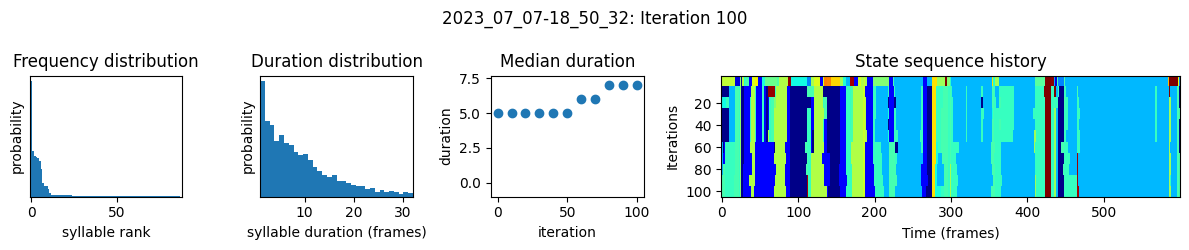

 30%|██▉       | 59/200 [1:00:58<2:25:02, 61.72s/it]

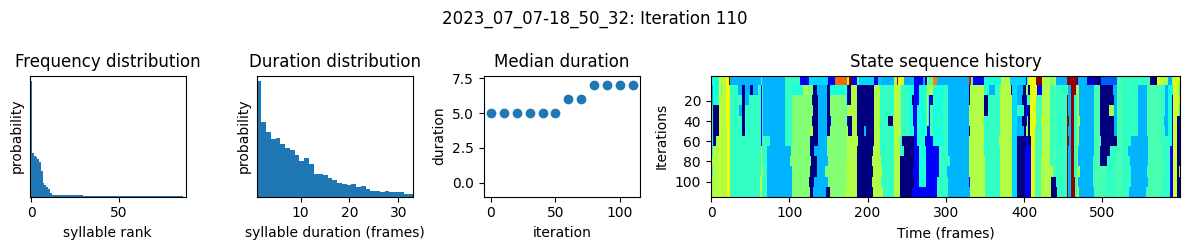

 34%|███▍      | 69/200 [1:11:15<2:14:37, 61.66s/it]

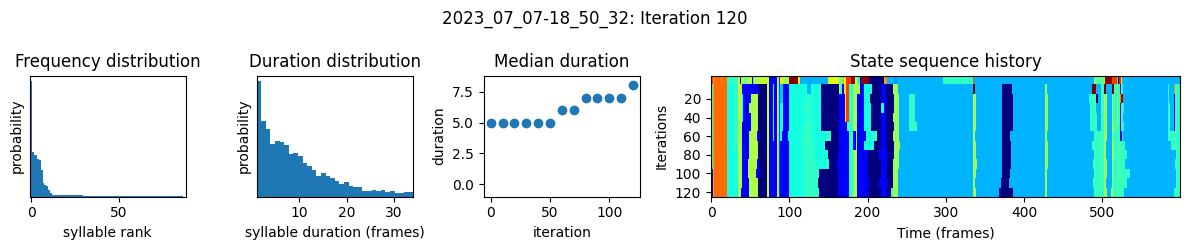

 40%|███▉      | 79/200 [1:21:34<2:04:31, 61.75s/it]

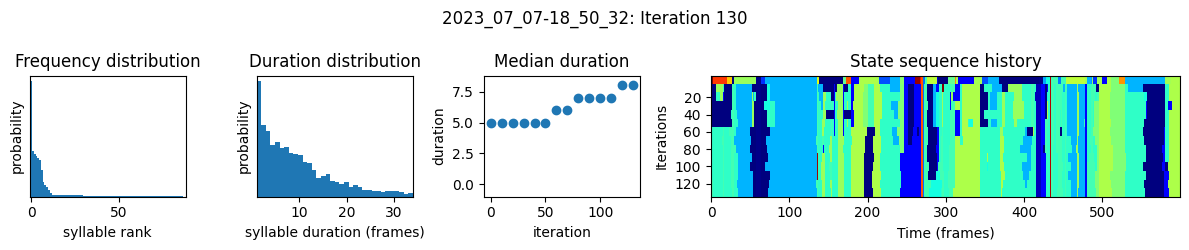

 44%|████▍     | 89/200 [1:31:52<1:54:10, 61.72s/it]

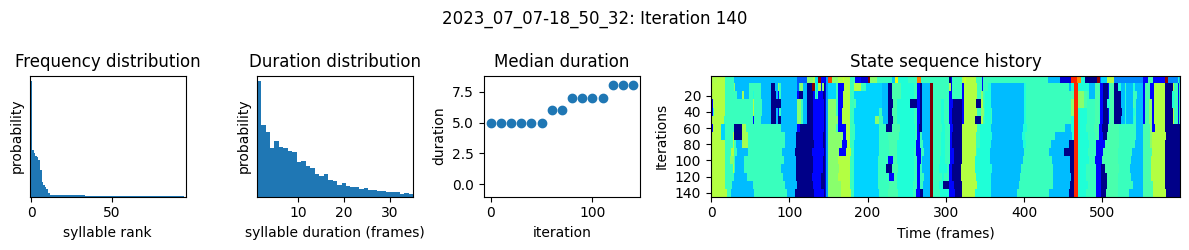

 50%|████▉     | 99/200 [1:42:10<1:43:49, 61.68s/it]

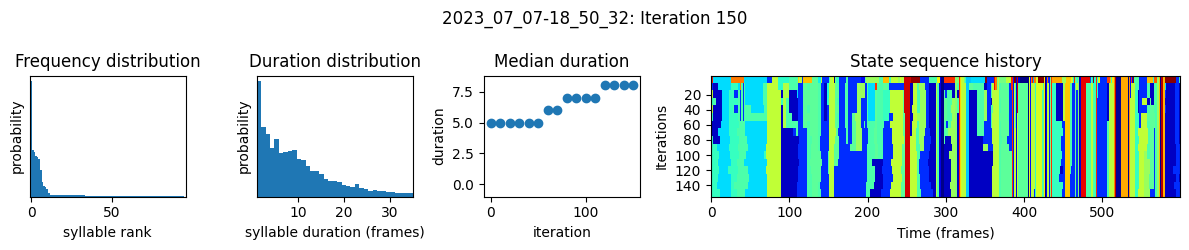

 55%|█████▍    | 109/200 [1:52:28<1:33:45, 61.82s/it]

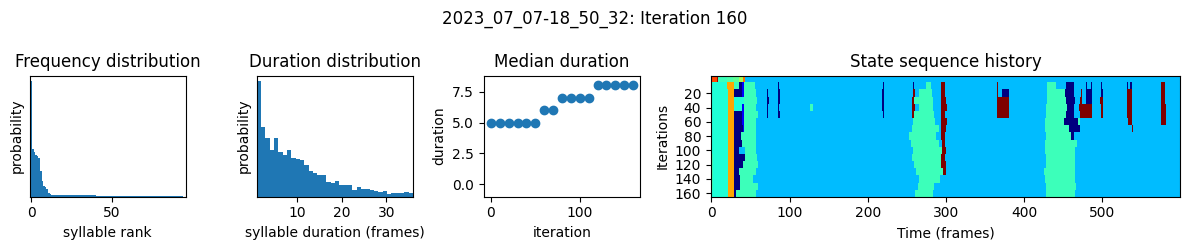

 60%|█████▉    | 119/200 [2:02:47<1:23:23, 61.77s/it]

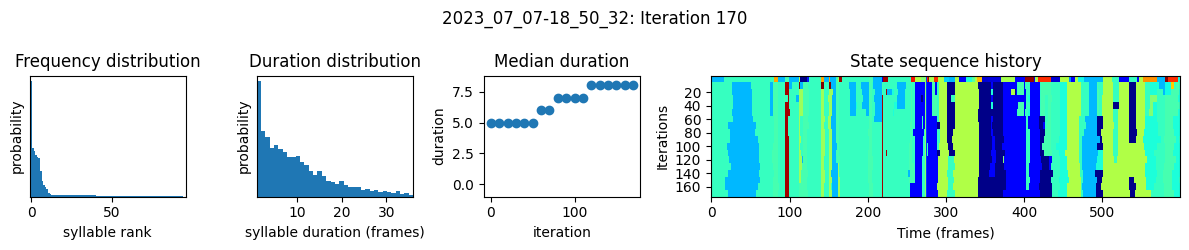

 64%|██████▍   | 129/200 [2:13:06<1:13:09, 61.83s/it]

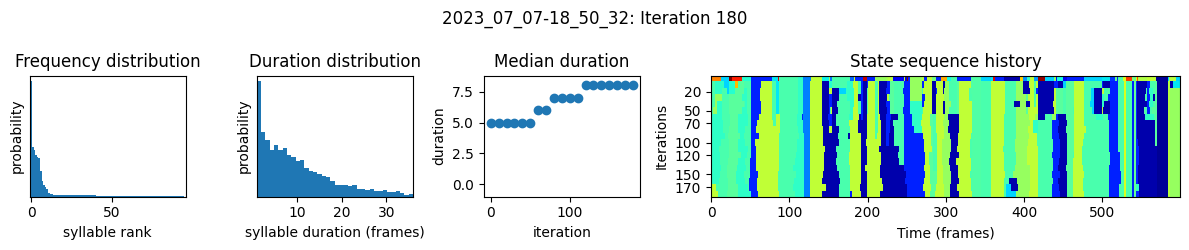

 70%|██████▉   | 139/200 [2:23:24<1:02:45, 61.74s/it]

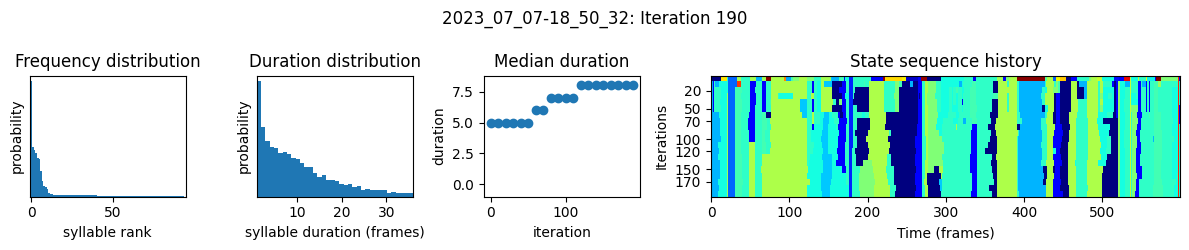

 74%|███████▍  | 149/200 [2:33:42<52:26, 61.70s/it]  

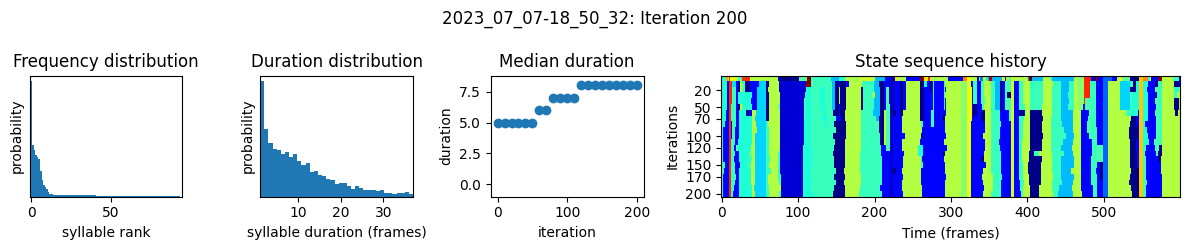

 80%|███████▉  | 159/200 [2:44:01<42:13, 61.80s/it]

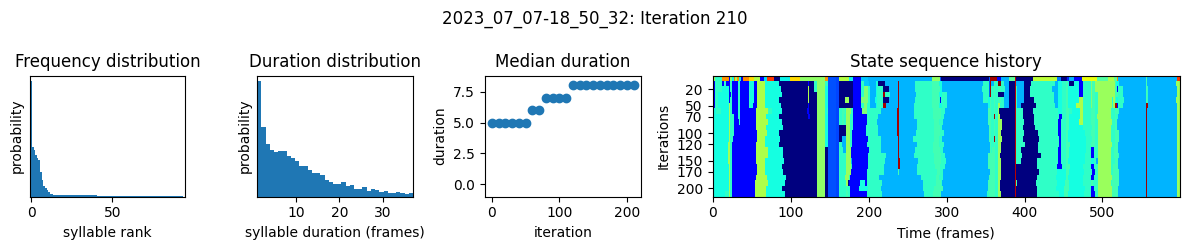

 84%|████████▍ | 169/200 [2:54:19<31:56, 61.81s/it]

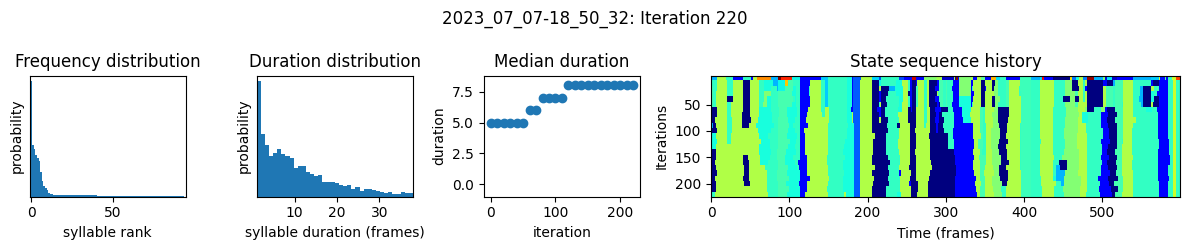

 90%|████████▉ | 179/200 [3:04:38<21:36, 61.74s/it]

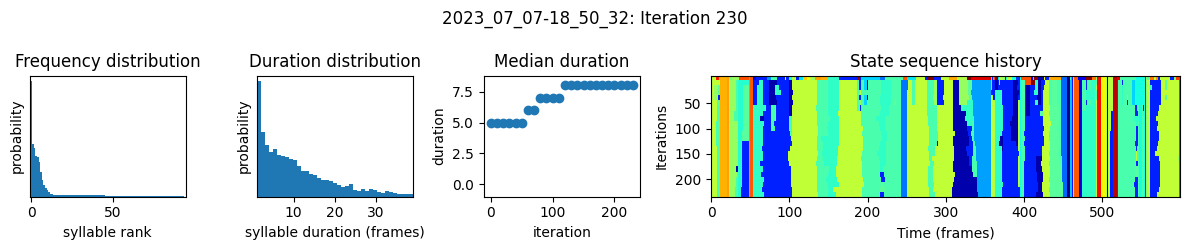

 94%|█████████▍| 189/200 [3:14:56<11:18, 61.71s/it]

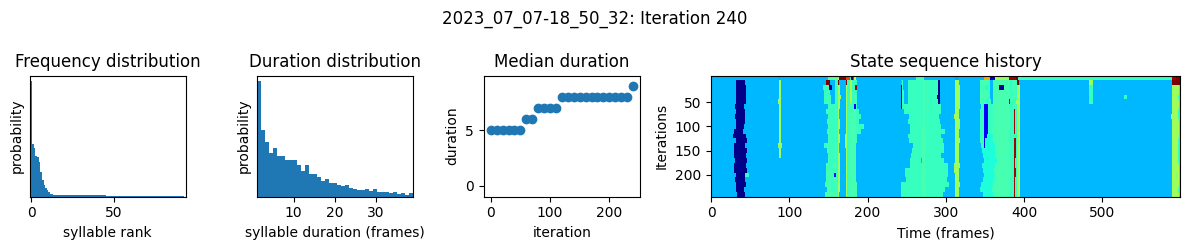

100%|█████████▉| 199/200 [3:25:14<01:01, 61.73s/it]

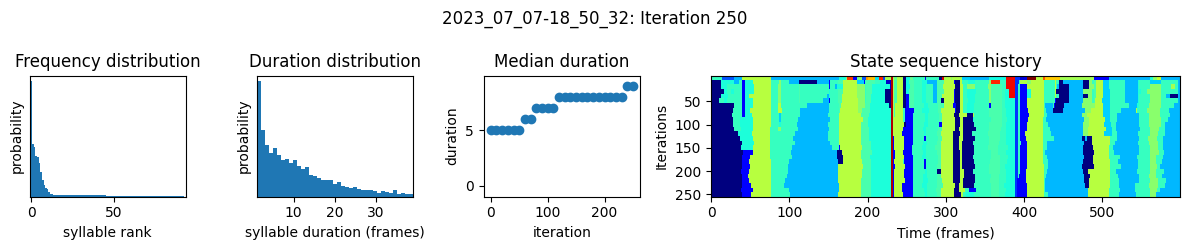

100%|██████████| 200/200 [3:26:17<00:00, 61.89s/it]


In [7]:
# load model checkpoint generated during step 2 (AR-HMM fitting)
checkpoint = kpms.load_checkpoint(project_dir=project_dir, name=name)

# the following will cause fitting to resume from iteration 50, rather than the most recent iteration
# checkpoint = kpms.revert(checkpoint, 50)

# update kappa to maintain the desired syllable time-scale
checkpoint = kpms.update_hypparams(checkpoint, kappa=9e4)

model, history, name = kpms.resume_fitting(**checkpoint, project_dir=project_dir, 
                                           ar_only=False, num_iters=200)

## Extract model results

Extract modeling results for each session and save the results to `{project_dir}/{name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`:
```
    results.h5
    ├──session_name1
    │  ├──estimated_coordinates  # denoised coordinates
    │  ├──syllables_reindexed    # syllables reindexed by frequency
    │  ├──syllables              # non-reindexed syllables labels (z)
    │  ├──latent_state           # inferred low-dim pose state (x)
    │  ├──centroid               # inferred centroid (v)
    │  └──heading                # inferred heading (h)
    ⋮
```
Checkout the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).

In [3]:
name = '2023_07_07-18_50_32'
# load saved model checkpoint
checkpoint = kpms.load_checkpoint(project_dir=project_dir, name=name)

# extract results
results = kpms.extract_results(project_dir=project_dir, **config(), **checkpoint)

Saved results to C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-
moseq/AVATAR/pilot_test/2023_07_07-18_50_32\results.h5


### Save results in csv format

After extracting to an h5 file, the results can optionally be saved in csv format. A separate csv file will be created for each session and saved to `{project_dir}/{name}/results/`. 

In [4]:
# optionally save results as csv
kpms.save_results_as_csv(project_dir=project_dir, name=name, **config())

Saving to csv: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


## Apply to new data

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [ ]:
# load saved model checkpoint
checkpoint = kpms.load_checkpoint(project_dir=project_dir, name=name)

# load new data (e.g. from deeplabcut)
new_data = 'path/to/new/data/' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut')


results = kpms.apply_model(
    coordinates=coordinates, 
    confidences=confidences, 
    project_dir=project_dir, 
    name=name, 
    pca=kpms.load_pca(project_dir),
    params=checkpoint['params'],
    hypparams=checkpoint['hypparams'],
    **config())

# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(project_dir=project_dir, name=name, **config())

# Visualization

## Trajectory plots
Generate plots showing the average trajectory of poses associated with each given syllable. 

Loading keypoints: 100%|██████████| 5/5 [00:00<00:00, 28.25it/s]


Saving trajectory plots to C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/AVATAR/pilot_test/2023_07_07-18_50_32\trajectory_plots


Generating trajectory plots: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


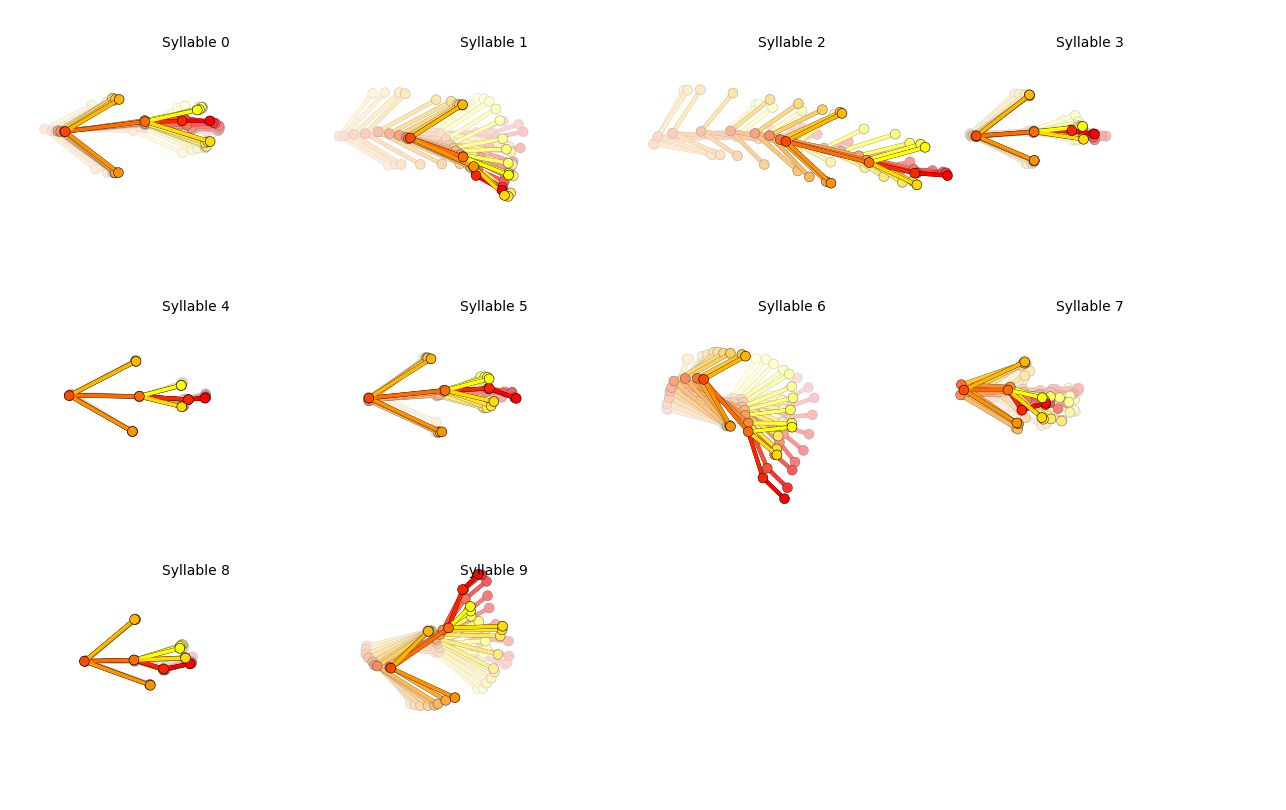

Generating trajectory plots: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


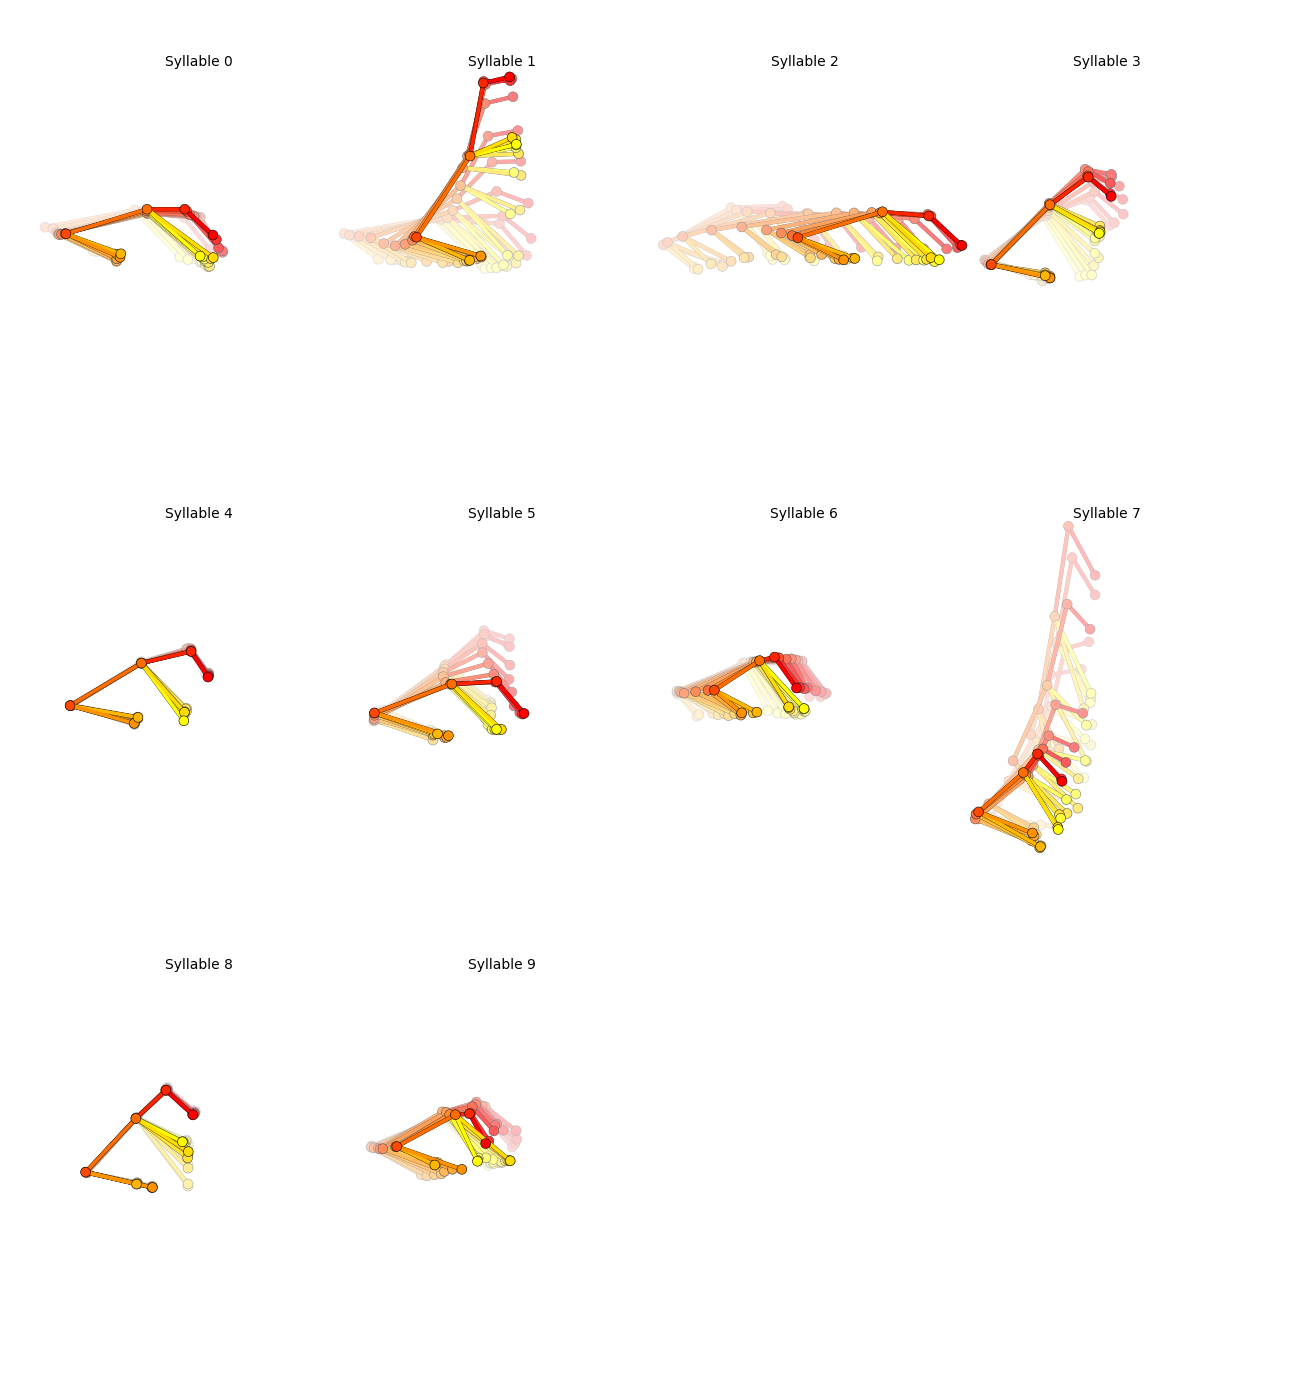

In [2]:
# run this code after creating a project

import keypoint_moseq as kpms

project_dir = 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/AVATAR/pilot_test/'
video_dir= [r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_111.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_112.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_113.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_121.csv',
r'C:\Users\MyPC\Desktop\실험실\2.실험데이터\AVATAR-AmD_이성민학생\dataset1\ko_s1d54_122.csv'
]
config = lambda: kpms.load_config(project_dir)
name = '2023_07_07-18_50_32'

# load data from AVATAR .csv file
keypoint_data_path = video_dir # can be a file, a directory, or a list of files
coordinates, bodyparts = kpms.load_keypoints_AVATAR(keypoint_data_path, path_sep='_', path_in_name=True, remove_extension=True)

# visualize results
kpms.generate_trajectory_plots(coordinates=coordinates, name=name, project_dir=project_dir, **config())

## Crowd & grid movies
Generate video clips showing examples of each syllable.

In [3]:
kpms.generate_grid_movies(name=name, project_dir=project_dir, coordinates=coordinates, **config())
kpms.generate_crowd_movies(name=name, project_dir=project_dir, coordinates=coordinates, **config())

Writing grid movies to C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/AVATAR/pilot_test/2023_07_07-18_50_32\grid_movies


AssertionError: No matching videos found for C:_Users_MyPC_Desktop_실험실_2.실험데이터_AVATAR-
AmD_이성민학생_dataset1_ko_s1d54_111